In [1]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import seaborn as sns
# File paths
customers_path = "Customers.csv"
products_path = "Products.csv"
transactions_path = "Transactions.csv"

# Load datasets
customers_df = pd.read_csv(customers_path)
products_df = pd.read_csv(products_path)
transactions_df = pd.read_csv(transactions_path)

# Display basic information about the datasets
customers_df.info(), customers_df.head(), products_df.info(), products_df.head(), transactions_df.info(), transactions_df.head()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   CustomerID    200 non-null    object
 1   CustomerName  200 non-null    object
 2   Region        200 non-null    object
 3   SignupDate    200 non-null    object
dtypes: object(4)
memory usage: 6.4+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   ProductID    100 non-null    object 
 1   ProductName  100 non-null    object 
 2   Category     100 non-null    object 
 3   Price        100 non-null    float64
dtypes: float64(1), object(3)
memory usage: 3.2+ KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  


(None,
   CustomerID        CustomerName         Region  SignupDate
 0      C0001    Lawrence Carroll  South America  2022-07-10
 1      C0002      Elizabeth Lutz           Asia  2022-02-13
 2      C0003      Michael Rivera  South America  2024-03-07
 3      C0004  Kathleen Rodriguez  South America  2022-10-09
 4      C0005         Laura Weber           Asia  2022-08-15,
 None,
   ProductID              ProductName     Category   Price
 0      P001     ActiveWear Biography        Books  169.30
 1      P002    ActiveWear Smartwatch  Electronics  346.30
 2      P003  ComfortLiving Biography        Books   44.12
 3      P004            BookWorld Rug   Home Decor   95.69
 4      P005          TechPro T-Shirt     Clothing  429.31,
 None,
   TransactionID CustomerID ProductID      TransactionDate  Quantity  \
 0        T00001      C0199      P067  2024-08-25 12:38:23         1   
 1        T00112      C0146      P067  2024-05-27 22:23:54         1   
 2        T00166      C0127      P067  20

In [2]:
# Convert date columns to datetime format
customers_df["SignupDate"] = pd.to_datetime(customers_df["SignupDate"])
transactions_df["TransactionDate"] = pd.to_datetime(transactions_df["TransactionDate"])

# Merge transactions with products data to get product details
transactions_merged = transactions_df.merge(products_df, on="ProductID", how="left")

# Merge with customers data to get customer details
full_data = transactions_merged.merge(customers_df, on="CustomerID", how="left")

# Display the first few rows of the merged dataset
full_data.head()


,TransactionID,CustomerID,ProductID,TransactionDate,Quantity,TotalValue,Price_x,ProductName,Category,Price_y,CustomerName,Region,SignupDate
0,T00001,C0199,P067,2024-08-25 12:38:23,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Andrea Jenkins,Europe,2022-12-03
1,T00112,C0146,P067,2024-05-27 22:23:54,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Brittany Harvey,Asia,2024-09-04
2,T00166,C0127,P067,2024-04-25 07:38:55,1,300.68,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Kathryn Stevens,Europe,2024-04-04
3,T00272,C0087,P067,2024-03-26 22:55:37,2,601.36,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Travis Campbell,South America,2024-04-11
4,T00363,C0070,P067,2024-03-21 15:10:10,3,902.04,300.68,ComfortLiving Bluetooth Speaker,Electronics,300.68,Timothy Perez,Europe,2022-03-15


In [3]:

# Reference date for recency calculation (assume the latest transaction date in dataset)
reference_date = full_data["TransactionDate"].max()

# Aggregate transaction data per customer
customer_features = full_data.groupby("CustomerID").agg(
    TotalSpend=("TotalValue", "sum"),
    TransactionCount=("TransactionID", "count"),
    AvgPurchaseValue=("TotalValue", "mean"),
    LastTransaction=("TransactionDate", "max"),
    SignupDate=("SignupDate", "min"),
    SpendingVariance=("TotalValue", "std"),
    PopularCategory=("Category", lambda x: x.mode()[0] if not x.mode().empty else "Unknown")
).reset_index()
# Fill missing values in SpendingVariance with 0 (for customers with only one transaction)
customer_features["SpendingVariance"].fillna(0, inplace=True)

# Drop unnecessary date columns
customer_features.drop(columns=["LastTransaction", "SignupDate"], inplace=True)

# Display processed customer features
customer_features.head()


,CustomerID,TotalSpend,TransactionCount,AvgPurchaseValue,SpendingVariance,PopularCategory
0,C0001,3354.52,5,670.904,456.643861,Electronics
1,C0002,1862.74,4,465.685,219.519169,Clothing
2,C0003,2725.38,4,681.345,559.276543,Home Decor
3,C0004,5354.88,8,669.360,325.386829,Books
4,C0005,2034.24,3,678.080,310.820746,Electronics


from sklearn.preprocessing import OneHotEncoder

In [4]:


encoder = OneHotEncoder(sparse_output=False, drop="first")
encoded_categories = encoder.fit_transform(customer_features[["PopularCategory"]])

encoded_df = pd.DataFrame(encoded_categories, columns=encoder.get_feature_names_out(["PopularCategory"]))
customer_features_encoded = pd.concat([customer_features.drop(columns=["PopularCategory"]), encoded_df], axis=1)


from sklearn.preprocessing import MinMaxScaler


In [5]:

scaler = MinMaxScaler()
scaled_features = scaler.fit_transform(customer_features_encoded.drop(columns=["CustomerID"]))
customer_features_scaled = pd.DataFrame(scaled_features, columns=customer_features_encoded.columns[1:])


In [6]:
# Display processed and scaled features
customer_features_scaled.head()

,TotalSpend,TransactionCount,AvgPurchaseValue,SpendingVariance,PopularCategory_Clothing,PopularCategory_Electronics,PopularCategory_Home Decor
0,0.308942,0.4,0.474336,0.400352,0.0,1.0,0.0
1,0.168095,0.3,0.308940,0.192458,1.0,0.0,0.0
2,0.249541,0.3,0.482751,0.490333,0.0,0.0,1.0
3,0.497806,0.7,0.473092,0.285275,0.0,0.0,0.0
4,0.184287,0.2,0.480120,0.272505,0.0,1.0,0.0


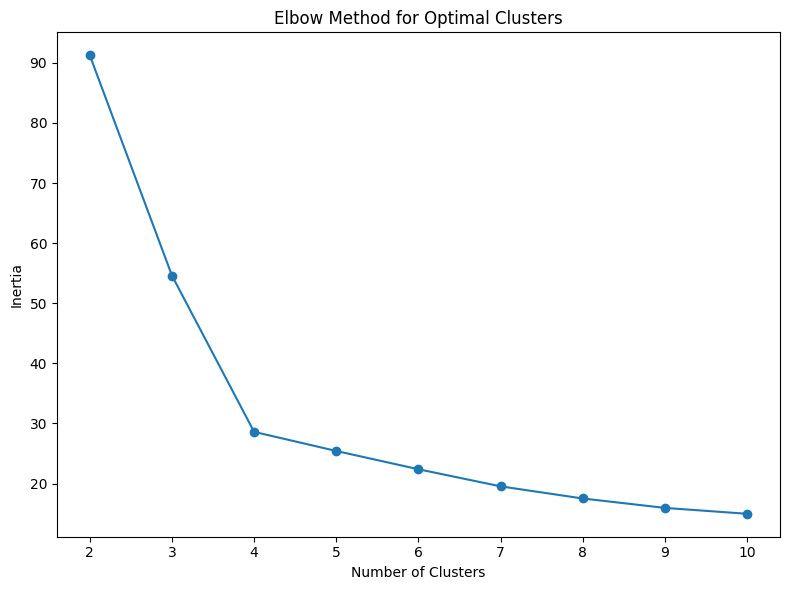

In [7]:
## Determine Optimal Clusters

inertia = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, n_init=10, random_state=42)
    kmeans.fit(customer_features_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(range(2, 11), inertia, marker='o')
plt.title("Elbow Method for Optimal Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Inertia")
plt.tight_layout()
plt.show()

In [8]:
best_db_index = float("inf")
best_k = None
best_labels = None

for k in range(2, 11):  # Testing between 2 to 10 clusters
    kmeans = KMeans(n_clusters=k,n_init=10, random_state=42)
    labels = kmeans.fit_predict(customer_features_scaled)
    db_index = davies_bouldin_score(customer_features_scaled, labels)
    
    print(f"Clusters: {k}, DB Index: {db_index}")
    
    if db_index < best_db_index:
        best_db_index = db_index
        best_k = k
        best_labels = labels

print(f"Optimal Cluster Count: {best_k}, Best DB Index: {best_db_index}")


Clusters: 2, DB Index: 0.9798399245599851
Clusters: 3, DB Index: 0.8751917066851016
Clusters: 4, DB Index: 0.677217256422354
Clusters: 5, DB Index: 0.7504381405101049
Clusters: 6, DB Index: 0.8950087885539403
Clusters: 7, DB Index: 0.9666159006174214
Clusters: 8, DB Index: 1.0870714200944307
Clusters: 9, DB Index: 1.03169249867073
Clusters: 10, DB Index: 1.092469877299776
Optimal Cluster Count: 4, Best DB Index: 0.677217256422354


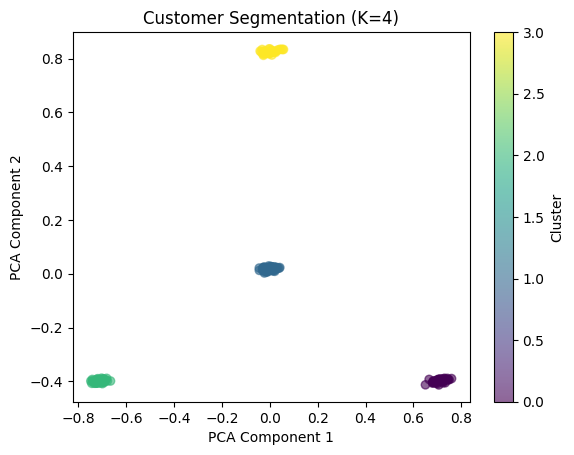

In [9]:
pca = PCA(n_components=2)
reduced_data = pca.fit_transform(customer_features_scaled)

plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c=best_labels, cmap="viridis", alpha=0.6)
plt.title(f"Customer Segmentation (K={best_k})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster")
plt.show()
